In [545]:
# For Reference 
# Date;Time;BTC/USD Bid;BTC/USD Bid Size;BTC/USD Ask;BTC/USD Ask Size;BTC/EUR Bid;BTC/EUR Bid Size;BTC/EUR Ask;BTC/EUR Ask Size;ETH/BTC Bid;ETH/BTC Bid Size;ETH/BTC Ask;ETH/BTC Ask Size;EUR/USD Bid;EUR/USD Bid Size;EUR/USD Ask;EUR/USD Ask Size;ETH/USD Bid;ETH/USD Bid Size;ETH/USD Ask;ETH/USD Ask Size;ETH/EUR Bid;ETH/EUR Bid Size;ETH/EUR Ask;ETH/EUR Ask Size

In [546]:
# Note datetime is the module name, but datetime is a class two. To call the datetime class use datetime.datetime
import datetime

In [547]:
def remove_from_str(s, substrings_to_remove) -> str:
    """
    Pretty inefficient but whatever.
    Use regex for speedup.
    """
    ret = s
    for sub in substrings_to_remove:
        ret = ret.replace(sub, "")
    return(ret)

In [548]:
def next_interval(t: datetime.datetime) -> datetime.datetime:
    """
    Return the next 5 minute interval
    """
    return(t + datetime.timedelta(minutes=5))

# print(datetime.datetime(2021, 9, 13, 12, 10))
# print(next_interval(datetime.datetime(2021, 9, 13, 12, 10)))

In [549]:
chars_to_remove = {'$', '€', ',', "BTC"}
f = open("Assignment 1 - Data.txt", 'r')
text = f.read()

rows = text.split('\n')

In [550]:
d = dict()
t = []
indexes = dict()

columns = rows[0].split(';')

for trade_type in columns[2:]:
    d[trade_type] = dict()

for i in range(len(columns)):
    indexes[i] = columns[i] 


In [551]:
#Setting up dictionary for easy lookup
for row in rows[1:]:
    split = row.split(';')
    # print(split)
    for i in range(len(split)):
        if i == 0:
            date = split[i]
        elif i == 1:
            time_of_day = split[i]
        else:
            trade_time = datetime.datetime.strptime(date + ' ' + time_of_day, "%m/%d/%Y %I:%M %p")
            trade_type = indexes[i]
            d[trade_type][trade_time] = float(remove_from_str(split[i], chars_to_remove))

            

In [552]:
#Setting up times and 
times = []
for i in d:
    for j in d[i]:
        times.append(j)
    break
times.sort()

#USD, EUR, BTC, ETH
currency = [1000,0,0,0]

In [553]:
total = 0

numslots = len(times)
buyBTC_USD = [0 for n in range(0, numslots-1)]
buyBTC_EUR = [0 for n in range(0, numslots-1)]
buyETH_BTC = [0 for n in range(0, numslots-1)]
buyETH_USD = [0 for n in range(0, numslots-1)]
buyETH_EUR = [0 for n in range(0, numslots-1)]
#Compare if you can sell to bid by buying ask
for i in range(0, numslots - 1):
    if d['BTC/USD Bid'][times[i+1]] > d['BTC/USD Ask'][times[i]]:
        buyBTC_USD[i] = d['BTC/USD Bid'][times[i+1]] * d['BTC/USD Ask Size'][times[i]] \
            - d['BTC/USD Ask'][times[i]] * d['BTC/USD Ask Size'][times[i]]
        

    if d['BTC/EUR Bid'][times[i+1]] > d['BTC/EUR Ask'][times[i]]:
        buyBTC_EUR[i] = d['BTC/EUR Bid'][times[i+1]] - d['BTC/EUR Ask'][times[i]]

    if d['ETH/BTC Bid'][times[i+1]] > d['ETH/BTC Ask'][times[i]]:
        buyETH_BTC[i] = d['ETH/BTC Bid'][times[i+1]] - d['ETH/BTC Ask'][times[i]]

    if d['ETH/USD Bid'][times[i+1]] > d['ETH/USD Ask'][times[i]]:
        buyETH_USD[i] = d['ETH/USD Bid'][times[i+1]] - d['ETH/USD Ask'][times[i]]
        
    if d['ETH/EUR Bid'][times[i+1]] > d['ETH/EUR Ask'][times[i]]:
        buyETH_EUR[i] = d['ETH/EUR Bid'][times[i+1]] - d['ETH/EUR Ask'][times[i]]

#print(buyBTC_USD)
#print(buybid)
# for i in d:
#     print(i)
#     print(d[i])
output = [[]]
maxusd = [1000]
stringoutput = ['']

print(times[0].strftime("%m/%d/%y %I:%M%p"))



09/13/21 12:00AM


In [554]:
def portfolio_value(prices, inventory):
    usd_value = 0
    for i in range(len(prices)):
        usd_value += prices[i] * inventory[i]
    return(usd_value)

def buy_or_sell(order_name):
    if order_name is None:
        return("NONE")
    if "Bid" in order_name:
        return("BUY")
    return("SELL")

In [555]:
# Add three pair
trade_set = [["BTC/USD Ask", "BTC/EUR Bid", "ETH/EUR Ask", "ETH/USD Bid"], 
["ETH/USD Ask", "ETH/EUR Bid", "BTC/EUR Ask", "BTC/USD Bid"], ["EUR/USD Ask", "ETH/EUR Bid", "ETH/BTC Ask", "BTC/USD Bid"], 
["BTC/USD Ask", "ETH/BTC Bid", "ETH/EUR Ask", "EUR/USD Bid"],
["ETH/USD Ask", "ETH/BTC Bid", "BTC/EUR Ask", "EUR/USD Bid"],
["EUR/USD Ask", "BTC/EUR Bid", "ETH/BTC Ask", "ETH/USD Ask"]]
portfolio_values = []

def new_method():
    portfolio_value = 1
    max_profit = 0
    best_trades = None
    shares = None
    outstr = ""
    for t in times:
        for trades in trade_set:
            if len(trades) == 4:
                end_value = portfolio_value / d[trades[0]][t] * d[trades[1]][t] / d[trades[2]][t] * d[trades[3]][t]
                profit = end_value - portfolio_value
                share0 = portfolio_value / d[trades[0]][t]
                share1 = portfolio_value / d[trades[1]][t]
                share2 = portfolio_value / d[trades[2]][t]
                share3 = portfolio_value / d[trades[3]][t]
                sizes = []
                for trade in trades:
                    sizes.append(d[trade + " Size"][t])
                min_flow = min(sizes)
                profit = (min_flow / share0) * profit
            elif len(trades) == 3:
                # Ugh 
                pass

            if profit > max_profit:
                max_profit = profit
                best_trades = trades
                best_shares = [share0, share1, share2, share3]
            

        if best_trades is None:
            outstr += str(t.strftime("%m/%d/%y;%I:%M%p")) + ";BUY,;SELL,;$0;0" + '\n'
        else:
            # DATE;TIME;BUY,Currency1-QTY,Currency2-QTY;SELL,Currency1-QTY,Currency2-QTY;PROFIT;NET POSITION
            outstr += str(t.strftime("%m/%d/%y;%I:%M%p")) + ";BUY,{}-{},{}-{};SELL,{}-{},{}-{};{};{}".\
                format(best_trades[1], best_shares[1], best_trades[3], best_shares[3], best_trades[0], best_shares[0], best_trades[2], best_shares[2], max_profit, 0) + '\n'

        portfolio_value += max_profit
        portfolio_values.append(portfolio_value)
    return((portfolio_value, outstr, portfolio_values))
value, out, y = new_method()
print(value)
f = open("output.txt", 'w')
f.write(out)
f.close()

195729618488952.3


In [556]:
# Inventory: USD, EUR, BTC, ETH
# GREEDY 
# Strategy is the choose the best trade that yields the most profit base on the ending prices of all the assets relative to USD. The most profitable trade is measured by price of the asset and the of asset.  
end_prices = [1, 1.16, 24135.56, 2941.99] # End prices in USD
orders = ["BTC/USD Bid", "BTC/USD Ask", "BTC/EUR Bid", "BTC/EUR Ask", "ETH/BTC Bid", "ETH/BTC Ask", "EUR/USD Bid", "EUR/USD Ask", "ETH/USD Bid", "ETH/USD Ask", "ETH/EUR Bid", "ETH/EUR Ask"]
# This is the indexes each currency corresponds to in the orders array
conversions = {0 : (1, 7, 9), 1 : (3, 6, 11,), 2: (0, 2, 5), 3: (4, 8, 10)} # Ex: USD is converted in "BTC/USD Ask",  "EUR/USD Ask", "ETH/USD Ask"
# This is to convert a string back into a index
currencies = {"USD" : 0, "EUR" : 1, "BTC" : 2, "ETH" : 3}
inventories = [] # Plz append inventory to inventories
def calculate_with_end_prices(end_prices, inventory):
    for t in times:
        max_profit = 0
        max_profit_trade = None
        max_profit_volume = 0
        max_profit_ratio = None
        for order in orders: 
            order_kind = order
            order_kind_size = order_kind + " Size"
            # print(order_kind)
            if "Bid" in order_kind:
                # Ex BTC/USD Bid * BTC/USD Bid Size = $48,064.80 * 9.4296 in BTC to be sold 
                # Ex "ETH/EUR Bid"
                start_currency = order_kind[:3]
                end_currency = order_kind[4:7] # Currency we will get by selling start currency 
                max_volume = min(inventory[currencies[start_currency]], d[order_kind_size][t]) # Volume relative to start 
                profit = d[order_kind][t]  * max_volume * end_prices[currencies[end_currency]] - max_volume * end_prices[currencies[start_currency]]
            elif "Ask" in order_kind:
                # This is where we buy the denominator
                # BTC/USD Ask * BTC/USD Ask Size = $48,269.41 * 18.2923 in BTC to be bought 
                start_currency = order_kind[4:7]
                end_currency = order_kind[:3]
                max_volume = min(inventory[currencies[start_currency]], d[order_kind][t] * d[order_kind_size][t])
                profit = 1 / d[order_kind][t] * max_volume * end_prices[currencies[end_currency]] - max_volume * end_prices[currencies[start_currency]]
            if profit > max_profit:
                max_profit = profit
                max_profit_trade = order_kind
                max_profit_volume = max_volume
                max_profit_ratio = d[order_kind][t]

        # Calculate change in inventory 
        if max_profit_trade == None: # No profitable trade 
            print(str(t.strftime("%m/%d/%y;%I:%M%p")) + ';'+'NOTHING;')
            pass
        elif "Bid" in max_profit_trade:
            increase = max_profit_trade[4:7]
            decrease = max_profit_trade[:3]
            inventory[currencies[increase]] += max_profit_volume * max_profit_ratio
            inventory[currencies[decrease]] -= max_profit_volume
            print(str(t.strftime("%m/%d/%y;%I:%M%p")) + ';'+'SELL,'+max_profit_trade[0:7]+'-{};'.format(max_profit_volume))
        elif "Ask" in max_profit_trade:
            increase = max_profit_trade[:3]
            decrease = max_profit_trade[4:7]
            inventory[currencies[increase]] += max_profit_volume / max_profit_ratio
            inventory[currencies[decrease]] -= max_profit_volume
            print(str(t.strftime("%m/%d/%y;%I:%M%p")) + ';'+'BUY,'+max_profit_trade[0:7]+'-{};'.format(max_profit_volume))
        #print(inventory, max_profit_trade, max_profit)
        inventories.append(inventory.copy())
    return(inventory)

ans = calculate_with_end_prices(end_prices, [1000, 0, 0, 0])
print(ans)
# Hack to calculate portfolio price 
print(portfolio_value(end_prices, ans))
    

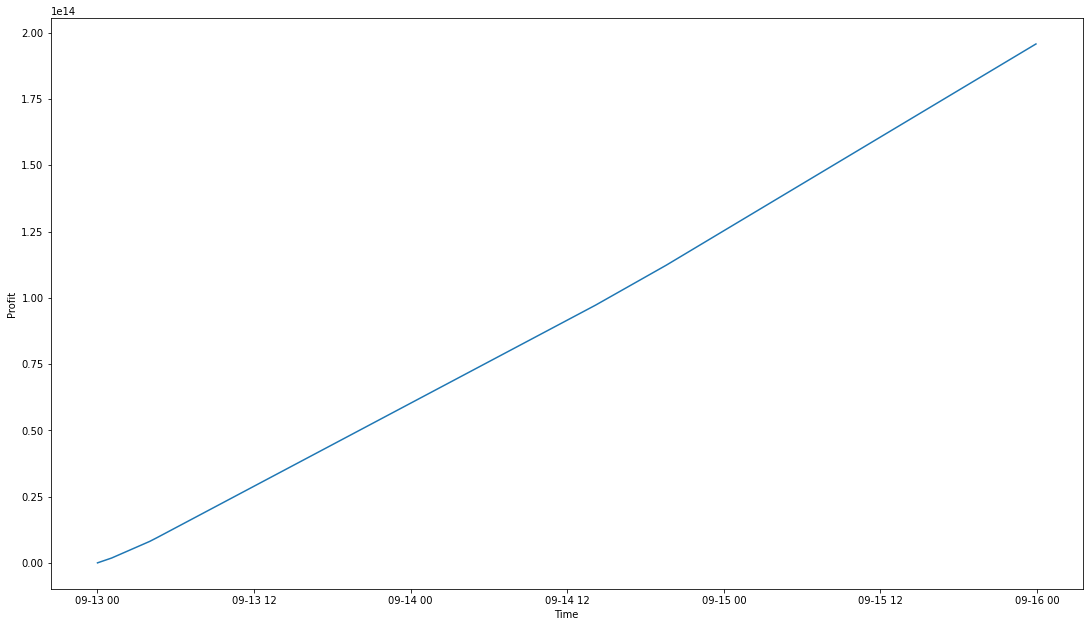

In [557]:
import matplotlib.pyplot as plt
x = times

plt.plot(x, y)
# plt.yscale('log')
plt.xlabel("Time")
plt.ylabel("Profit")
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig("fig.png", dpi = 500)
plt.show()


    

In [558]:
# '''
# INVENTORY INDEX:
# 0 = USD
# 1 = EUR
# 2 = BTC
# 3 = ETH
# '''
# #transaction = ['BTC/USD Bid', 'BTC/USD Ask', 'BTC/EUR Bid', 'BTC/EUR Ask', 'ETH/BTC Bid', 'ETH/BTC Ask', 'EUR/USD Bid', 'EUR/USD Ask', 'ETH/USD Bid', 'ETH/USD Ask', 'ETH/EUR Bid', 'ETH/EUR Ask', 'Nothing']
# # We first get the minimum of each of the values of the currencies relative to USD. Once we do we can see if your portfolio has lost more than 1% of its value at the min. If so, then we stop searching the tree
# def combo(inventory, datetimeIndex, outputstring):
#     ####### HARD CODED CONTENT (MODIFY HERE LATER) #########
#     if portfolio_value([1, 1.18, 39651.80, 3162.61], inventory) < 990:
#         if inventory[0] > maxusd[0]:
#             maxusd[0] = inventory[0]
#             output[0] = inventory
#             stringoutput[0] = outputstring
#         return
#     ########################################################

#     if datetimeIndex == len(times):
#         if inventory[0] > maxusd[0]:
#             maxusd[0] = inventory[0]
#             output[0] = inventory
#             stringoutput[0] = outputstring
#         return
#     if inventory[0] > 0:
#         usd_tobuy_btc_total = min(d['BTC/USD Ask'][times[datetimeIndex]] * d['BTC/USD Ask Size'][times[datetimeIndex]], inventory[0])
#         btc_count = usd_tobuy_btc_total / d['BTC/USD Ask'][times[datetimeIndex]]
#         tempstring = outputstring + str(times[datetimeIndex].strftime("%m/%d/%y %I:%M%p")) + ';BUY,BTC/USD-{};'.format(btc_count)
#         combo([inventory[0] - usd_tobuy_btc_total, inventory[1], inventory[2] + btc_count, inventory[3]], datetimeIndex + 1, tempstring)

#         usd_tobuy_eth_total = min(d['ETH/USD Ask'][times[datetimeIndex]] * d['ETH/USD Ask Size'][times[datetimeIndex]], inventory[0])
#         eth_count = usd_tobuy_eth_total / d['ETH/USD Ask'][times[datetimeIndex]]
#         tempstring = outputstring + str(times[datetimeIndex].strftime("%m/%d/%y %I:%M%p")) + ';BUY,ETH/USD-{};'.format(eth_count)
#         combo([inventory[0] - usd_tobuy_eth_total, inventory[1], inventory[2], inventory[3] + eth_count], datetimeIndex + 1, tempstring)

#         usd_tobuy_eur_total = min(d['EUR/USD Ask'][times[datetimeIndex]] * d['EUR/USD Ask Size'][times[datetimeIndex]], inventory[0])
#         eur_count = usd_tobuy_eur_total / d['EUR/USD Ask'][times[datetimeIndex]]
#         tempstring = outputstring + str(times[datetimeIndex].strftime("%m/%d/%y %I:%M%p")) + ';BUY,EUR/USD-{};'.format(eur_count)
#         combo([inventory[0] - usd_tobuy_eur_total, inventory[1] + eur_count, inventory[2], inventory[3]], datetimeIndex + 1, tempstring)

#     if inventory[1] > 0:
#         eur_tobuy_btc_total = min(d['BTC/EUR Ask'][times[datetimeIndex]] * d['BTC/EUR Ask Size'][times[datetimeIndex]], inventory[1])
#         btc_count = eur_tobuy_btc_total / d['BTC/EUR Ask'][times[datetimeIndex]]
#         tempstring = outputstring + str(times[datetimeIndex].strftime("%m/%d/%y %I:%M%p")) + ';BUY,BTC/EUR-{};'.format(btc_count)
#         combo([inventory[0], inventory[1] - eur_tobuy_btc_total, inventory[2] + btc_count, inventory[3]], datetimeIndex + 1, tempstring)

#         eur_tobuy_eth_total = min(d['ETH/EUR Ask'][times[datetimeIndex]] * d['ETH/EUR Ask Size'][times[datetimeIndex]], inventory[1])
#         eth_count = eur_tobuy_eth_total / d['ETH/EUR Ask'][times[datetimeIndex]]
#         tempstring = outputstring + str(times[datetimeIndex].strftime("%m/%d/%y %I:%M%p")) + ';BUY,ETH/EUR-{};'.format(eth_count)
#         combo([inventory[0], inventory[1] - eur_tobuy_eth_total, inventory[2], inventory[3] + eth_count], datetimeIndex + 1, tempstring)

#         eur_tobuy_usd_total = min(d['EUR/USD Bid Size'][times[datetimeIndex]] / d['EUR/USD Bid'][times[datetimeIndex]], inventory[1])
#         usd_count = eur_tobuy_usd_total * d['EUR/USD Bid'][times[datetimeIndex]]
#         tempstring = outputstring + str(times[datetimeIndex].strftime("%m/%d/%y %I:%M%p")) + ';SELL,EUR/USD-{};'.format(usd_count)
#         combo([inventory[0] + usd_count, inventory[1] - eur_tobuy_usd_total, inventory[2], inventory[3]], datetimeIndex + 1, tempstring)

#     if inventory[2] > 0:
#         btc_tobuy_usd_total = min(d['BTC/USD Bid Size'][times[datetimeIndex]] / d['BTC/USD Bid'][times[datetimeIndex]], inventory[2])
#         usd_count = btc_tobuy_usd_total * d['BTC/USD Bid'][times[datetimeIndex]]
#         tempstring = outputstring + str(times[datetimeIndex].strftime("%m/%d/%y %I:%M%p")) + ';SELL,BTC/USD-{};'.format(usd_count)
#         combo([inventory[0] + usd_count, inventory[1], inventory[2] - btc_tobuy_usd_total, inventory[3]], datetimeIndex + 1, tempstring)

#         btc_tobuy_eur_total = min(d['BTC/EUR Bid Size'][times[datetimeIndex]] / d['BTC/EUR Bid'][times[datetimeIndex]], inventory[2])
#         eur_count = btc_tobuy_eur_total * d['BTC/EUR Bid'][times[datetimeIndex]]
#         tempstring = outputstring + str(times[datetimeIndex].strftime("%m/%d/%y %I:%M%p")) + ';SELL,BTC/EUR-{};'.format(eur_count)
#         combo([inventory[0], inventory[1] + eur_count, inventory[2] - btc_tobuy_eur_total, inventory[3]], datetimeIndex + 1, tempstring)

#         btc_tobuy_eth_total = min(d['ETH/BTC Ask'][times[datetimeIndex]] * d['ETH/BTC Ask Size'][times[datetimeIndex]], inventory[2])
#         eth_count = btc_tobuy_eth_total / d['BTC/EUR Ask'][times[datetimeIndex]]
#         tempstring = outputstring + str(times[datetimeIndex].strftime("%m/%d/%y %I:%M%p")) + ';BUY,ETH/BTC-{};'.format(eth_count)
#         combo([inventory[0], inventory[1], inventory[2] - btc_tobuy_eth_total, inventory[3] + eth_count], datetimeIndex + 1, tempstring)
    
#     if inventory[3] > 0:
#         eth_tobuy_usd_total = min(d['ETH/USD Bid Size'][times[datetimeIndex]] / d['ETH/USD Bid'][times[datetimeIndex]], inventory[3])
#         usd_count = eth_tobuy_usd_total * d['ETH/USD Bid'][times[datetimeIndex]]
#         tempstring = outputstring + str(times[datetimeIndex].strftime("%m/%d/%y %I:%M%p")) + ';SELL,ETH/USD-{};'.format(usd_count)
#         combo([inventory[0] + usd_count, inventory[1], inventory[2], inventory[3] - eth_tobuy_usd_total], datetimeIndex + 1, tempstring)

#         eth_tobuy_eur_total = min(d['ETH/EUR Bid Size'][times[datetimeIndex]] / d['ETH/EUR Bid'][times[datetimeIndex]], inventory[3])
#         eur_count = eth_tobuy_eur_total * d['ETH/EUR Bid'][times[datetimeIndex]]
#         tempstring = outputstring + str(times[datetimeIndex].strftime("%m/%d/%y %I:%M%p")) + ';SELL,ETH/EUR-{};'.format(eur_count)
#         combo([inventory[0], inventory[1] + eur_count, inventory[2], inventory[3] - eth_tobuy_usd_total], datetimeIndex + 1, tempstring)

#         eth_tobuy_btc_total = min(d['ETH/BTC Bid Size'][times[datetimeIndex]] / d['ETH/BTC Bid'][times[datetimeIndex]], inventory[3])
#         btc_count = eth_tobuy_btc_total * d['ETH/BTC Bid'][times[datetimeIndex]]
#         tempstring = outputstring + str(times[datetimeIndex].strftime("%m/%d/%y %I:%M%p")) + ';SELL,ETH/BTC-{};'.format(btc_count)
#         combo([inventory[0], inventory[1], inventory[2] + btc_count, inventory[3] - eth_tobuy_btc_total], datetimeIndex + 1, tempstring)
    
#     tempstring = outputstring + str(times[datetimeIndex].strftime("%m/%d/%y %I:%M%p")) + ';DO NOTHING;'
#     combo(inventory, datetimeIndex + 1, tempstring)

# combo([1000,0,0,0],0,"")





